In [1]:
import numpy as np
import pandas as pd
from docxtpl import DocxTemplate
from docx2pdf import convert

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from docx.shared import Inches

In [2]:
def eistr(ei):
    if ei==0:
        string ='Нулевой'
    elif (0<ei<=0.5):
        string ='Первый'
    elif (0.5<ei<=0.7):
        string ='Второй'
    elif (0.7<ei<=0.85):
        string ='Третий'
    elif (0.85<ei<=0.9):
        string ='Четвертый'
    elif (0.9<ei<=1):
        string ='Пятый'
    return string
#________________________________________________________________

def acc(val, account):
  mas = []
  for i in range (len(val)):
    if account[i]=='Да':
      mas.append(val[i])
  return mas

def func2 (df1,df2, ind, context, stri ):
  sum1 = []
  e = df1
  zi=pd.read_excel(df2).iloc[:,1:].values
  val = e['Значение']
  account = e['Учет']
  for i in range(len(e)):
    context[stri+str(i+1)]=val[i]
    if account[i]=='Да':
      if zi[i][ind]!= 'H':
        sum1.append(val[i])
      elif (val[i]>0):
        sum1.append(val[i])
  ans = sum(sum1)/len(sum1)
  return ans, context
#________________________________________________________________

def f1(ind, context, data, gost, k, numproc):
  new=[]
  m = gost.iloc[:, 1:].values
  per = data['Значение'].values
  ac = data['Учет'].values
  stri1 = 'p'+str(numproc)+'_account'+str(k)+'_'
  stri2 = 'p'+str(numproc)+'_mark'+str(k)+'_'
  for j in range(len(m)):
      context[stri1+str(j+1)]=ac[j]
      if (ac[j]=='Да'):
          if (m[j][ind]=='H'):
            if ((per[j]=='T') or (per[j]=='O')):
              new.append(1)
              context[stri2+str(j+1)]=1
            else:
              context[stri2+str(j+1)]='-'
          elif (m[j][ind]=='O'):
            if ((per[j]=='T') or (per[j]=='O')):
              new.append(1)
              context[stri2+str(j+1)]=1
            else:
              new.append(0)
              context[stri2+str(j+1)]=0
          elif (m[j][ind]=='T'):
            new.append(int(m[j][ind] == per[j]))
            context[stri2+str(j+1)]=int(m[j][ind] == per[j])
      else:
        context[stri2+str(j+1)] = '-'
  ppzi = sum(new)/len(new)
  return context, ppzi
#________________________________________________________________

def allp (ls, context, numproc, data1, gost, data2): 
    ind = 3 - int(ls)
    
    n = ((pd.ExcelFile(data1)).sheet_names)
    
    stri = 'sp'+str(numproc)+'_mark_'
    ppzi = []
    k = 0
    for i in n:
        k += 1
        df = pd.read_excel(data1, sheet_name = i)
        #print(df)
        gst = pd.read_excel(gost, sheet_name = i)
        #print(gst)
        sp = f1(ind, context, df, gst, k, numproc)
        context = sp[0]
        ppzi.append(sp[1])
        context[stri+str(k)]=round(sp[1], 2)
        
    pzi = sum(ppzi)/len(ppzi)
    
#Планирование процесса системы
    dat=pd.read_excel(data2, sheet_name = 'PZI')
    val = dat['Значение']
    stri = 'p'+str(numproc)+'_pzi'
    for i in range (len(val)):
        context[stri+str(i+1)]=val[i]
    account = dat['Учет']
    emoun = acc(val, account)
    eni = sum(emoun)/len(emoun)

#Реализация процесса системы
    stri = 'p'+str(numproc)+'_rzi'
    epi = func2(pd.read_excel(data2, sheet_name = 'RZI'), 'RZIdata.xlsx', ind, context, stri)

#Контроль процесса системы
    stri = 'p'+str(numproc)+'_czi'
    eki = func2(pd.read_excel(data2, sheet_name = 'KZI'), 'KZIdata.xlsx', ind, epi[1], stri)
    context = eki[1]

#Совершенствование процесса системы
    dat=pd.read_excel(data2, sheet_name = 'SZI')
    val = dat['Значение']
    stri ='p'+str(numproc)+'_szi'
    for i in range (len(val)):
        context[stri+str(i+1)]=val[i]
    account = dat['Учет']
    emoum = acc(val, account)
    ecj = sum(emoum)/len(emoum)
    

    eac = 0 
#Оценка уровня соответствия процессов системы 
    ei = (pzi+0.2*eni+0.4*epi[0]+0.25*eki[0]+0.15*ecj)/2
    return (pzi, eni, epi[0], eki[0], ecj, eac, ei, context)
#________________________________________________________________

def proc(np, context, eifin):
    print ('Введите уровень защищенности для процесса ', np)
    ls = input()
#
    koef = allp (ls, context, np, 
             'data1_p'+str(np)+'.xlsx',  #data
            'gost_p'+str(np)+'.xlsx', #gost
            'data2_p'+str(np)+'.xlsx') #data
    ei = koef[6]
    context = koef[7]
    context['Eki_'+str(np)] = round(koef[3],2)
    context['Rate_'+str(np)] = eistr(ei)
    context['Epzi_'+str(np)] = round(koef[0],2)
    context['Epi_'+str(np)]= round(koef[1],2)
    context['Eni_'+str(np)]=round(koef[2],2)
    context['Eci_'+str(np)]=round(koef[4],2)
    context['Ei_'+str(np)]= round(ei,2)
    context['p'+str(np)+'_mark'] = round(koef[0],2)
    context['p'+str(np)+'_pzi_total'] = round(koef[1],2)
    context['p'+str(np)+'_rzi_total'] = round(koef[2],2)
    context['p'+str(np)+'_czi_total'] = round(koef[3],2)
    context['p'+str(np)+'_szi_total'] = round(koef[4],2)
    eifin = eifin+ei
    return context, eifin
#________________________________________________________________

def lc(data, context):
    lc = pd.read_excel(data)
    val = lc['Значение']
    account = lc['Учет']
    stri = 'lc_mark'
    stri2 = 'lc_account'
    for i in range (len(val)):
        context[stri+str(i+1)]=val[i]
        context[stri2+str(i+1)]=account[i]
    emoun = acc(val, account)
    eac = sum(emoun)/len(emoun)
    context['lc_mark'] = round(eac, 2)
    context['Eac'] = round(eac, 2)
    return context, eac
#________________________________________________________________
def lep_gr(pr, context):
    labels = []
    stats = []
    for i in pr:
        labels.append('Процесс '+ i)
        stats.append(context['Ei_'+i])
    labels.append(labels[0])

    angles=np.linspace(0, 2*np.pi, len(labels)-1, endpoint=False)
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))


    fig = plt.figure(figsize = (7, 7))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-',label = 'Данные организации', linewidth=2)

    y = []
    for i in range(len(pr)+1):
        y.append(0.71)

    ax.plot(angles, y, 'o-', label ='Требования ЦБ', linewidth=2)
    ax.legend()
    ax.fill(angles, stats, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi,labels )
    ax.set_title('График числовой оценки соответствия процесса системы ЗИ  \n')
    ax.grid(True)
    plt.savefig('gr1.png')
#________________________________________________________________

def nap_gr (pr, context):
    x1 = np.arange(1, len(pr)+1) - 0.3
    x2 = np.arange(1, len(pr)+1) - 0.1
    x3 = np.arange(1, len(pr)+1) + 0.1
    x4 = np.arange(1, len(pr)+1) + 0.3

    y1 = []
    y2 = []
    y3 = []
    y4 = []
    for i in pr:
        y1.append(context['p'+str(i)+'_pzi_total'])
        y2.append(context['p'+str(i)+'_rzi_total'])
        y3.append(context['p'+str(i)+'_czi_total'])
        y4.append(context['p'+str(i)+'_szi_total'])

    fig, ax = plt.subplots()
    ax.bar(x1, y1, width = 0.2, label = 'Планирование')
    ax.bar(x2, y2, width = 0.2,  label = 'Реализация')
    ax.bar(x3, y3, width = 0.2,  label = 'Контроль')
    ax.bar(x4, y4, width = 0.2, label = 'Совершенствование')
    ax.legend()

    ax.set_title('График оценки по направлениям ЗИ системы организации и управления ЗИ  \n')
    ax.set_xlabel('\n ПРОЦЕСС')
    fig.set_figwidth(12)    
    fig.set_figheight(6)    
    plt.xticks(np.arange(1, len(pr)+1), pr)
    plt.legend
    plt.savefig('gr2.png')

Введите количество рассматриваемых процессов
3
Введите номера рассматриваемых процессов
1
2
3
Введите уровень защищенности для процесса  1
3
Введите уровень защищенности для процесса  2
3
Введите уровень защищенности для процесса  3
3
Введите количество нарушений
0


  0%|          | 0/1 [00:00<?, ?it/s]

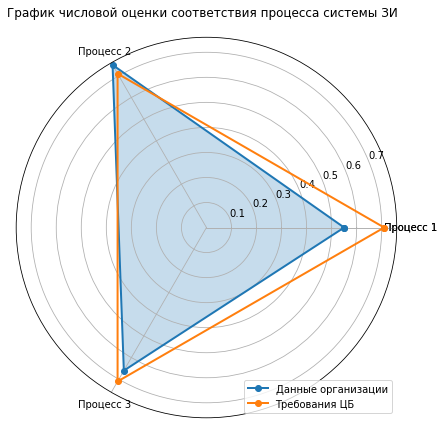

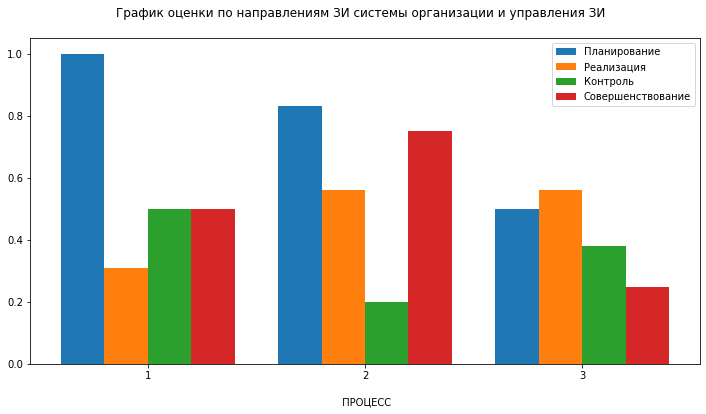

In [3]:
doc = DocxTemplate("Report.docx")
print ('Введите количество рассматриваемых процессов')
cp = input()
print('Введите номера рассматриваемых процессов')
pr = []
for i in range(int(cp)):
    pr.append(input())
context = {}
eifin = 0
for i in pr:
    context, eifin = proc(i, context, eifin)
context, eac = lc('lc.xlsx', context)
print ('Введите количество нарушений')
Z = int(input())
context['Z'] = Z
R = (eifin+eac)/(int(cp)+1)-0.01*Z
context['E'] = round(R,2)
context['RateFinal'] = eistr(R)
lep_gr(pr, context)
nap_gr(pr, context)
doc.add_picture("gr1.png")
doc.add_picture("gr2.png", width=Inches(7.0), height = Inches(5.0))
doc.render(context)
doc.save("Отчет.docx")
convert('Отчет.docx')